In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Employee turnover analysis project that is built by using Python’s Scikit-Learn library.

In [ ]:
import pandas as pd
hr = pd.read_csv('../input/HR_comma_sep.csv')
col_names = hr.columns.tolist()
print("Column names:")
print(col_names)
print("\nSample data:")
hr.head()

Looking at the dataset, we can see the features that are there:

1. **satisfaction_level** (0–1)
2. **last_evaluation** (Time since last evaluation in years)
3. **number_projects** (Number of projects completed while at work)
4. **average_monthly_hours** (Average monthly hours at workplace)
5. **time_spend_company** (Time spent at the company in years)
6. **Work_accident** (Whether the employee had a workplace accident)
7.**left** (Whether the employee left the workplace or not (1 or 0))
8. **promotion_last_5years** (Whether the employee was promoted in the last five years)
9.** sales **(Department in which they work for)
10. **salary** (Relative level of salary)


Let's rename the sales column to department.

In [ ]:
hr=hr.rename(columns = {'sales':'department'})

In [ ]:
hr.isnull().any()

Data looks clean. Let's look at its shape and types of columns.


In [ ]:
hr.dtypes

In [ ]:
hr.shape

The department column of the dataset has many categories and we need to reduce the categories for a better modeling

In [ ]:
hr['department'].unique()

Let us combine “technical”, “support” and “IT” together and call them “technical”

In [ ]:
import numpy as np
hr['department']=np.where(hr['department'] =='support', 'technical', hr['department'])
hr['department']=np.where(hr['department'] =='IT', 'technical', hr['department'])

In [ ]:
hr['department'].unique()

**DATA EXPLORATION**

Let us find out the number of employees who left the company and those who didn’t

In [ ]:
hr['left'].value_counts()

So 3571 employees left the company while 11428 stayed.

In [ ]:
hr.groupby('left').mean()

The average satisfaction level of employees who stayed with the company is higher than that of the employees who left.

In [ ]:
hr.groupby('department').mean()

In [ ]:
hr.groupby('salary').mean()

**Data Visualization**

Bar chart for department and the frequency of turnover('left')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
pd.crosstab(hr.department,hr.left).plot(kind='bar')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.savefig('department_bar_chart')

We can see that department is a good indicator for frequency of turnover. Now let us see a Bar chart for employee salary level and the frequency of turnover

In [ ]:
table=pd.crosstab(hr.salary, hr.left)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Salary Level vs Turnover')
plt.xlabel('Salary Level')
plt.ylabel('Proportion of Employees')
plt.savefig('salary_bar_chart')

Salary is a good indicator as well.

In [ ]:
num_bins = 10
hr.hist(bins=num_bins, figsize=(20,15))
plt.savefig("hr_histogram_plots")
plt.show()

Now for the categorical variables, salary and department, we need to create dummies.

In [ ]:
cat_vars=['department','salary']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr1=hr.join(cat_list)
    hr=hr1

In [ ]:
hr.drop(hr.columns[[8, 9]], axis=1, inplace=True)
hr.columns.values

In [ ]:
hr_vars=hr.columns.values.tolist()
y=['left']
X=[i for i in hr_vars if i not in y]
print(X)

Logistic Regression

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model, 10)
rfe = rfe.fit(hr[X], hr[y])
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
cols=['satisfaction_level', 'last_evaluation', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 
      'department_RandD', 'department_hr', 'department_management', 'salary_high', 'salary_low'] 
X=hr[cols]
y=hr['left']

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

In [ ]:
print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(y_test, rf.predict(X_test))))

Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
print('Support vector machine accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test))))

Random Forest is the most accurate one out of the three. Let's build a confusion matrix to infer more.

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3462
           1       0.95      0.95      0.95      1038

    accuracy                           0.98      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.98      0.98      0.98      4500



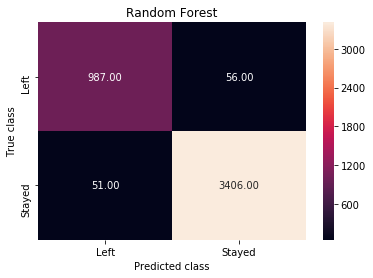

In [41]:
y_pred = rf.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
forest_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
sns.heatmap(forest_cm, annot=True, fmt='.2f',xticklabels = ["Left", "Stayed"] , yticklabels = ["Left", "Stayed"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')